# DATA

In [38]:
TRAIN_FLAG = True

In [39]:
import matplotlib.pyplot as plt

def plot_grid(data, grid_size=5):
    mat_data = data.data if hasattr(data, 'data') else data

    _, ax = plt.subplots(nrows=grid_size, ncols=grid_size, figsize=(8,8))

    for i in range(grid_size):
        for j in range(grid_size):
            ax[i][j].imshow(mat_data[i*grid_size+j].movedim(0, 2), cmap='gray')
            ax[i][j].axis('off')
    plt.tight_layout(pad=0.)

In [40]:
import torch
from torch.utils.data import Dataset
from pythae.data.datasets import DatasetOutput


class MNIST(Dataset):
    def __init__(self, data):
        self.data = data #.type(torch.float)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        return DatasetOutput(data=x)

In [41]:
import torch
from torch.utils.data import Dataset, ConcatDataset
from pythae.data.datasets import DatasetOutput
from torchvision import datasets

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)

In [42]:
from utils.data import sample_indices

train_indeces = sample_indices(mnist_trainset.targets, k=20, seed=42)

remaining_indeces = list(set(range(len(mnist_trainset.targets)))-set(train_indeces))
test_indeces = sample_indices(mnist_trainset.targets[remaining_indeces], k=5, seed=42)

In [43]:
train_dataset = mnist_trainset.data[train_indeces].reshape(-1, 1, 28, 28) / 255.
eval_dataset = mnist_trainset.data[test_indeces].reshape(-1, 1, 28, 28) / 255.
print(train_dataset.shape, eval_dataset.shape)

torch.Size([200, 1, 28, 28]) torch.Size([50, 1, 28, 28])


In [44]:
# train_mean, train_std = train_dataset.mean(), train_dataset.std()
# train_dataset -= train_mean / train_std
# eval_dataset -= train_mean / train_std

In [45]:
# train_dataset = MNIST(train_dataset)
# eval_dataset = MNIST(eval_dataset)

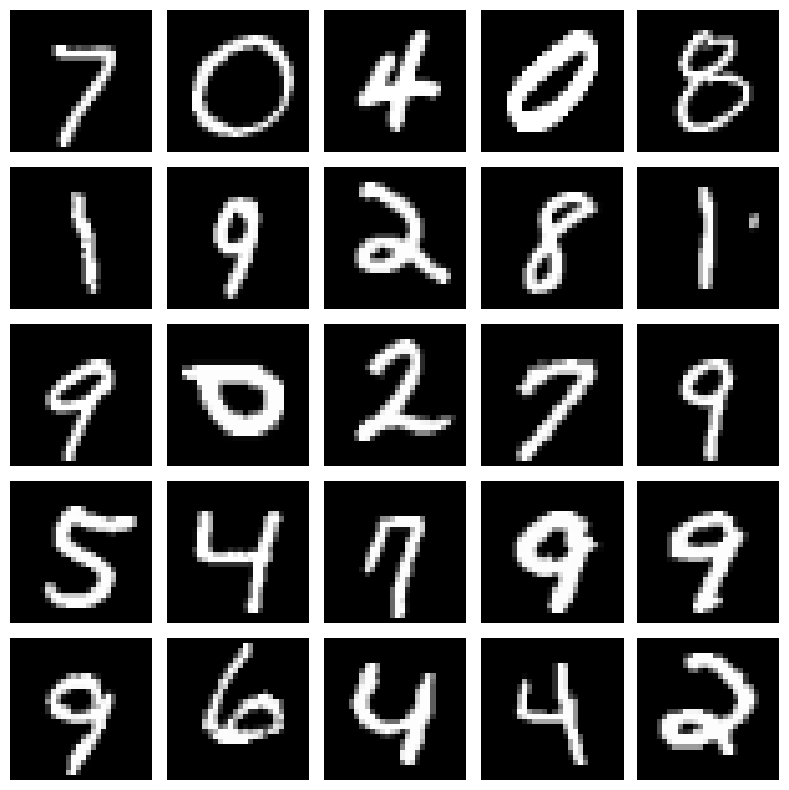

In [46]:
plot_grid(train_dataset.data)

# TRAIN

## Configure Training

In [47]:
from pythae.models import *
from pythae.models.nn.benchmarks.mnist import *
from pythae.models.nn.default_architectures import *
from pythae.models.base.base_utils import ModelOutput
from utils.models import Encoder_VAE_TinyMLP, Decoder_AE_TinyMLP

architecture_dict = {
    'tiny':
        {
        'encoder': Encoder_VAE_TinyMLP,
        'decoder': Decoder_AE_TinyMLP,
        },
    'mlp':
        {
        'encoder': Encoder_VAE_MLP,
        'decoder': Decoder_AE_MLP,
        },
    'convnet':
        {
        'encoder': Encoder_Conv_VAE_MNIST,
        'decoder': Decoder_Conv_AE_MNIST,
        },
    'resnet':
        {
        'encoder': Encoder_ResNet_VAE_MNIST,
        'decoder': Decoder_ResNet_AE_MNIST,
        },
    }


model_config = RHVAEConfig(
    input_dim=(1, 28, 28),
    latent_dim=16,
    reconstruction_loss="mse",
    n_lf=3,
    eps_lf=1e-3,
    beta_zero=0.3,
    temperature=0.8,
    regularization=1e-2
)

model = RHVAE(
    model_config=model_config,
    encoder=architecture_dict['resnet']['encoder'](model_config),
    decoder=architecture_dict['resnet']['decoder'](model_config),
)

# model_config = VAEConfig(
#     input_dim=(1, 28, 28),
#     latent_dim=8,
# )

# model = VAE(
#     model_config=model_config,
#     encoder=Encoder_ResNet_VAE_MNIST(model_config),
#     decoder=Decoder_ResNet_AE_MNIST(model_config)
# )

In [48]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

%time count_parameters(model)

CPU times: user 402 µs, sys: 0 ns, total: 402 µs
Wall time: 412 µs


1135225

In [49]:
print(model)

RHVAE(
  (decoder): Decoder_ResNet_AE_MNIST(
    (layers): ModuleList(
      (0): Linear(in_features=16, out_features=2048, bias=True)
      (1): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (2): Sequential(
        (0): ResBlock(
          (conv_block): Sequential(
            (0): ReLU()
            (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): ReLU()
            (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
          )
        )
        (1): ResBlock(
          (conv_block): Sequential(
            (0): ReLU()
            (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): ReLU()
            (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
          )
        )
        (2): ReLU()
      )
      (3): Sequential(
        (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
        (1): ReLU()
      )
 

## Early Stopping

In [50]:
from pytorch_lightning.callbacks import EarlyStopping
# early_stop_cb = EarlyStopping(
#     monitor='val_loss',
#     min_delta=1e-5,
#     patience=3,
#     verbose=False,
#     mode='min')

from pythae.trainers.training_callbacks import *

class EarlyStopping(TrainingCallback):
    def __init__(self, patience=5, min_delta=0, mode='min'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.best_metric = np.Inf if mode == 'min' else -np.Inf
        self.counter = 0
        self.early_stop = False

    def on_eval_step_end(self, training_config: BaseTrainerConfig, **kwargs):
        logger = kwargs.pop("logger", self.logger)

        if logger is not None:
            current_metric = logger.get("eval_epoch_loss", None)

            if self.mode == 'min':
                improvement = current_metric < self.best_metric - self.min_delta
            else:
                improvement = current_metric > self.best_metric + self.min_delta

            if improvement:
                self.best_metric = current_metric
                self.counter = 0
            else:
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True

            return self.early_stop

early_stop_cb = EarlyStopping(
    min_delta=10,
    patience=0,
    mode='min')

callbacks = []
callbacks.append(early_stop_cb)

## Train

In [51]:
from pythae.trainers import BaseTrainerConfig, BaseTrainer
from pythae.pipelines.training import TrainingPipeline

training_config = BaseTrainerConfig(
    output_dir='experiments',
    num_epochs=10,
    learning_rate=1e-3,
    per_device_train_batch_size=len(train_dataset),
    per_device_eval_batch_size=len(eval_dataset),
    #optimizer_params={'weight_decay':1e-4},
    scheduler_cls="ReduceLROnPlateau",
    scheduler_params={"patience": 5, "factor": 0.5, "verbose": True}
)

pipeline = TrainingPipeline(
        training_config=training_config,
        model=model
)

if TRAIN_FLAG:
    pipeline(
        train_data=train_dataset,
        eval_data=eval_dataset,
        #callbacks=callbacks
    )
else:
    pass

Preprocessing train data...
Checking train dataset...
Preprocessing eval data...

Checking eval dataset...
Using Base Trainer

Model passed sanity check !
Ready for training.

Created experiments/RHVAE_training_2024-04-24_17-24-51. 
Training config, checkpoints and final model will be saved here.

Training params:
 - max_epochs: 10
 - per_device_train_batch_size: 200
 - per_device_eval_batch_size: 50
 - checkpoint saving every: None
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7a07bbae4fa0>

Successfully launched training !



Training of epoch 1/10:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 1/10:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 116.5573
Eval loss: 117.7619
--------------------------------------------------------------------------


Training of epoch 2/10:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 2/10:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 109.9314
Eval loss: 109.8965
--------------------------------------------------------------------------


Training of epoch 3/10:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 3/10:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 101.1913
Eval loss: 86.7569
--------------------------------------------------------------------------


Training of epoch 4/10:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 4/10:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 101.1667
Eval loss: 100.8093
--------------------------------------------------------------------------


Training of epoch 5/10:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 5/10:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 92.5456
Eval loss: 96.9025
--------------------------------------------------------------------------


Training of epoch 6/10:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 6/10:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 89.5889
Eval loss: 93.8371
--------------------------------------------------------------------------


Training of epoch 7/10:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 7/10:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 86.0156
Eval loss: 89.9945
--------------------------------------------------------------------------


Training of epoch 8/10:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 8/10:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 82.3853
Eval loss: 89.0202
--------------------------------------------------------------------------


Training of epoch 9/10:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 9/10:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 79.9673
Eval loss: 84.2124
--------------------------------------------------------------------------


Training of epoch 10/10:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 10/10:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 77.9143
Eval loss: 78.5217
--------------------------------------------------------------------------
Training ended!
Saved final model in experiments/RHVAE_training_2024-04-24_17-24-51/final_model


# RECONSTRUCTIONS

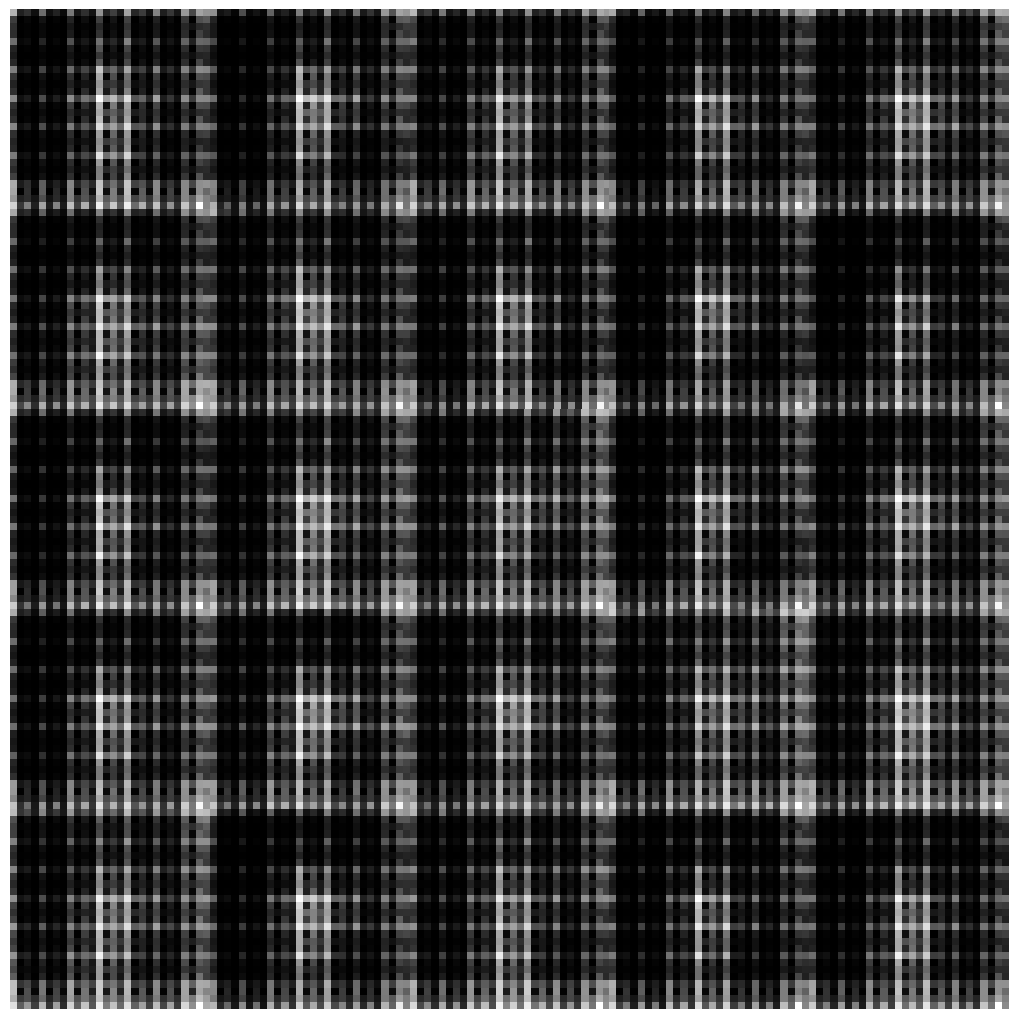

In [52]:
reconstructions = model.reconstruct(eval_dataset[:25]).detach().cpu()

# show reconstructions
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        axes[i][j].imshow(reconstructions[i*5 + j].cpu().squeeze(0), cmap='gray')
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)

# GENERATE

In [53]:
from pythae.models import AutoModel

import glob

# if TRAIN_FLAG:
#     trained_model = model
# else:
trained_model = AutoModel.load_from_folder(glob.glob('experiments/*/final_model')[0])

### Normal Sampler

In [54]:
from pythae.samplers import NormalSampler


sampler = NormalSampler(
    model=trained_model,
    sampler_config=None
)
gen_data = sampler.sample(
    num_samples=25,
)

In [55]:
plot_grid(gen_data.data)

### Gaussian Mixture Model Sampler

In [ ]:
from pythae.samplers import GaussianMixtureSampler, GaussianMixtureSamplerConfig


gmm_sampler_config = GaussianMixtureSamplerConfig(
    n_components=10
)

gmm_sampler = GaussianMixtureSampler(
    sampler_config=gmm_sampler_config,
    model=trained_model
)

gmm_sampler.fit(
    train_data=train_dataset
)

gmm_gen_data = gmm_sampler.sample(
   num_samples=25
)

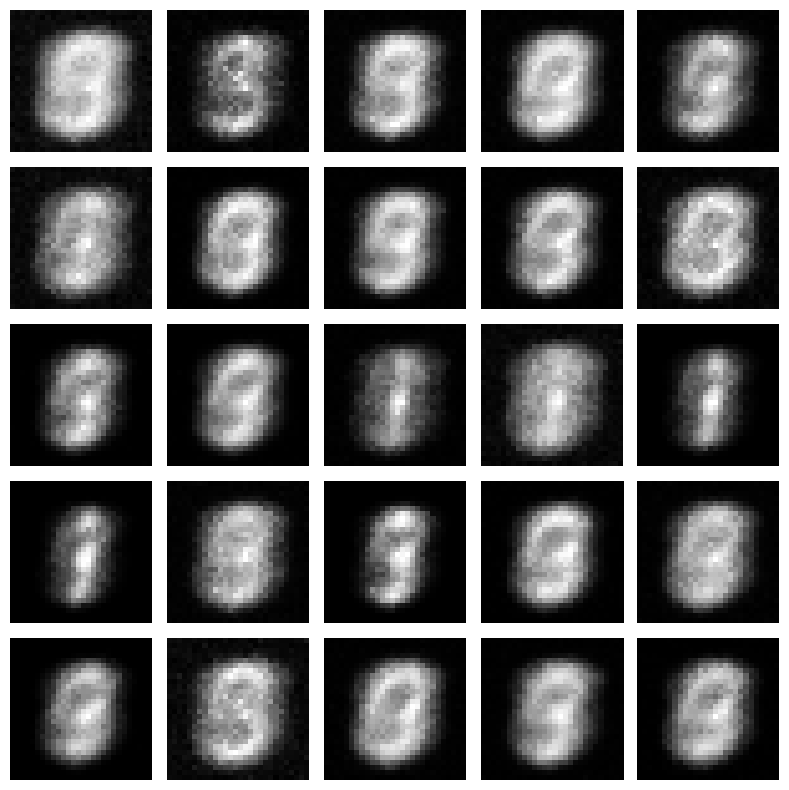

In [ ]:
plot_grid(gmm_gen_data.data)

### RHVAE Sampler

In [ ]:
from pythae.samplers import RHVAESampler, RHVAESamplerConfig


rh_sampler_config = RHVAESamplerConfig(
    # mcmc_steps_nbr = 200,
    # n_lf = 3,
    # eps_lf = 1e-3,
    # beta_zero = 0.3
)

rh_sampler = RHVAESampler(
    sampler_config=rh_sampler_config,
    model=trained_model
)

rh_sampler.fit(
    train_data=train_dataset
)

rh_gen_data = rh_sampler.sample(
   num_samples=25
)

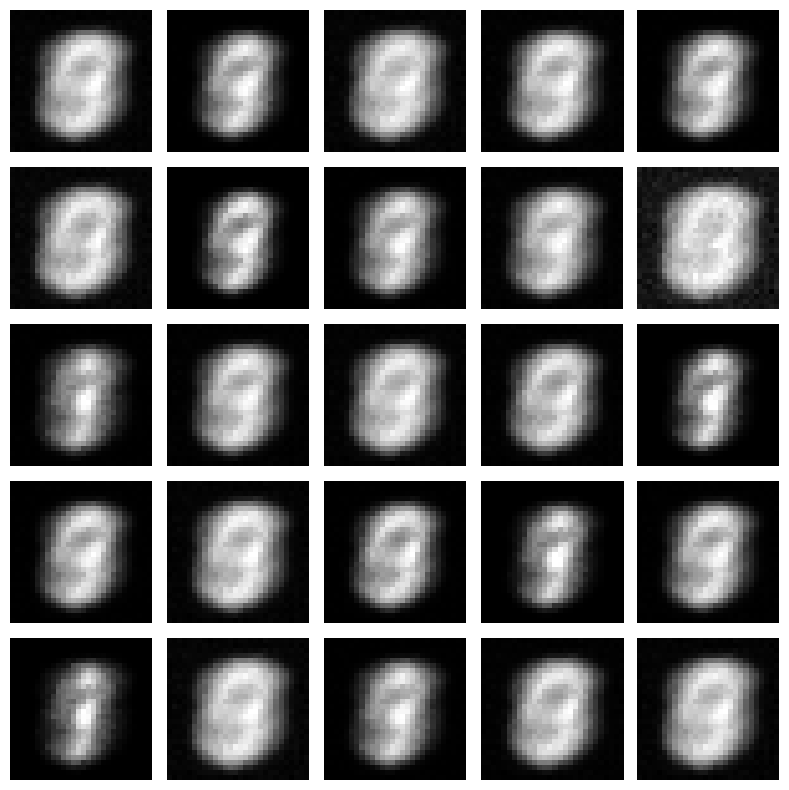

In [ ]:
plot_grid(rh_gen_data)

In [ ]:
rh_gen_data.shape

torch.Size([25, 1, 28, 28])

In [ ]:
#combined_dataset = ConcatDataset([train_dataset, rh_gen_data])
combined_dataset = torch.cat((train_dataset, rh_gen_data), 0)
combined_dataset = combined_dataset[torch.randperm(combined_dataset.size()[0])]
combined_dataset.shape

torch.Size([1225, 1, 28, 28])